In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns 
import xgboost
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE
from mlxtend.plotting import plot_confusion_matrix
from math import sqrt

In [3]:
df=pd.read_csv('./new_data.csv')
df = df.drop(df.columns[0], axis=1)
df=df.fillna(method='ffill')
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')

## With Outliers

In [4]:
# for val in df.isna().sum():
#     print (val)

In [4]:
# df=df.set_index('nDate')

/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


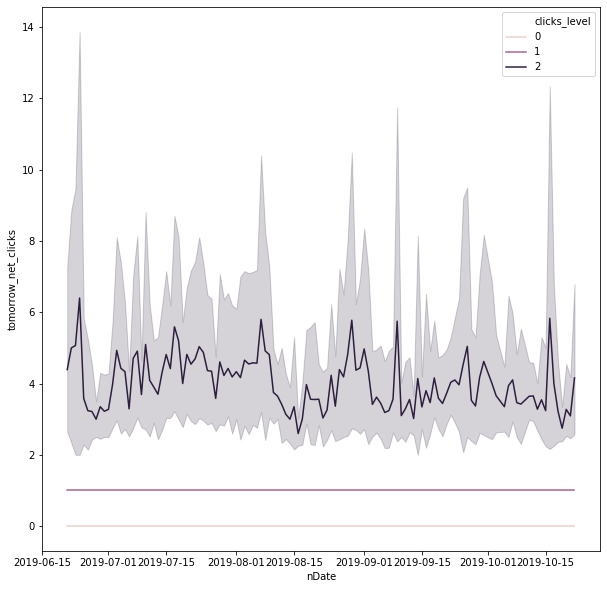

In [5]:
fig,ax=plt.subplots(figsize=(10,10))
sns.lineplot(ax=ax,x=df.nDate, y=df.tomorrow_net_clicks,hue=df.clicks_level)

## Outlier Removal

In [5]:
# def is_outlier(s):
#     lower_limit = s.mean() - (s.std() * 3)
#     upper_limit = s.mean() + (s.std() * 3)
#     return ~s.between(lower_limit, upper_limit)

In [4]:
stds=1.0
z=df.groupby('date').transform(lambda group: (group - group.mean()).div(group.std()))

In [5]:
outliers = z.abs()> stds
df_out=df[outliers.any(axis=1)]

In [6]:
df_out.clicks_level.value_counts()

0    670700
1      8458
2      3840
Name: clicks_level, dtype: int64

In [7]:
df_out=df_out.dropna()

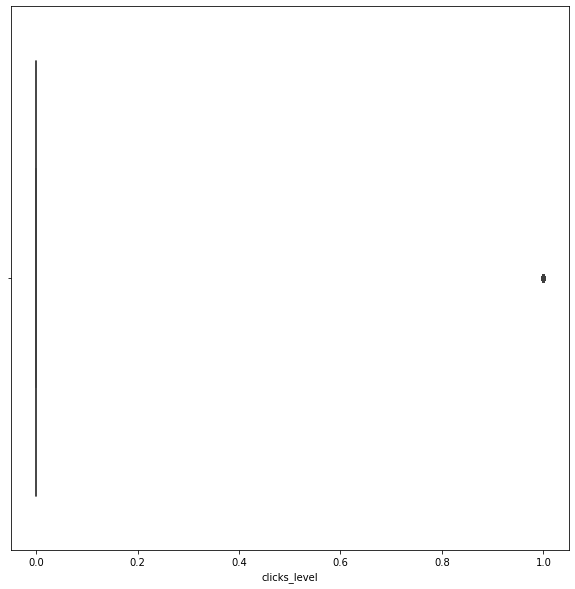

In [23]:
# fig,ax=plt.subplots(figsize=(10,10))
# sns.boxplot(x=df_out.clicks_level,ax=ax)

## Click Level Model

In [8]:
df_out.loc[df_out['clicks_level']==2, 'clicks_level'] =1
df_out.clicks_level.value_counts()

0    670699
1     12298
Name: clicks_level, dtype: int64

In [9]:
df.loc[df['clicks_level']==2, 'clicks_level'] =1
df.clicks_level.value_counts()

0    1157644
1      12298
Name: clicks_level, dtype: int64

In [8]:
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')

In [14]:
def build_model(lr=0.1,depth=5,estimators=10):
    clf=xgboost.XGBClassifier(learning_rate = lr,max_depth = depth,early_stopping_rounds=10,
                              n_estimators = estimators,n_jobs=-1,
                              sub_sample=0.6,
                              scale_pos_weight=61.74611520037388)
    return clf

In [11]:
# TimeSeries Split
train=df_out[df_out["nDate"]<'2019-09-15']
Y_train=train["clicks_level"]
X_train=train.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

test=df_out[df_out["nDate"]>='2019-09-15']
Y_test=test["clicks_level"]
X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

In [14]:
# ADASYN
sm = ADASYN(random_state=20,n_jobs=-1)
X_train_sm, y_train_sm = sm.fit_sample(X_train, Y_train)

In [13]:
(Y_train.value_counts()[0]/float(Y_train.value_counts()[1]))

61.74611520037388

In [15]:
np.unique(y_train_sm, return_counts=True)

(array([0, 1]), array([528485, 530255]))

In [26]:
# Cross Validation
ac=make_scorer(f1_score,average='macro')
model = build_model(lr=0.08,depth=3,estimators=20)
tscv = TimeSeriesSplit(n_splits=3)
scores = cross_val_score(model, X_train, Y_train, cv=tscv, scoring=ac)
print("F1: {0:.5f} (+/- {1:.5f})".format(scores.mean(), scores.std()))

F1: 0.63575 (+/- 0.01373)


In [28]:
model = build_model(lr=0.08,depth=3,estimators=20)
model.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
              gamma=0, learning_rate=0.08, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=20, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=61.74611520037388,
              seed=None, silent=None, sub_sample=0.6, subsample=1, verbosity=1)

In [19]:
pred=model.predict(X_test)

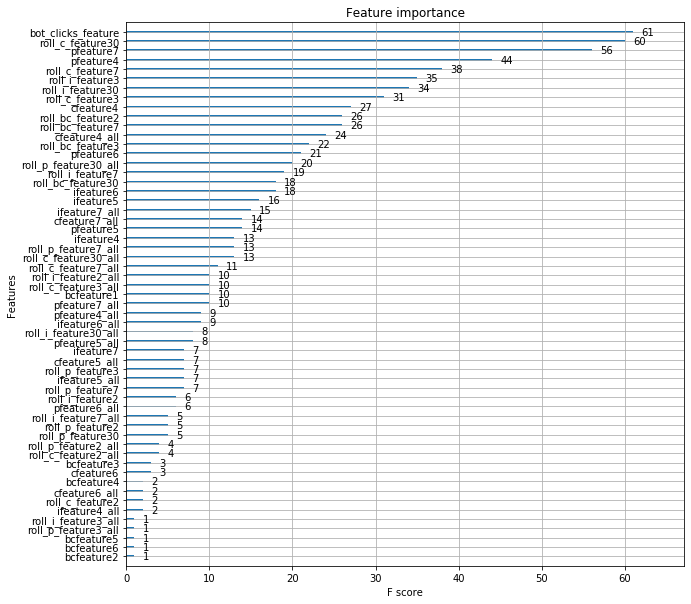

In [14]:
fig,ax=plt.subplots(figsize=(10,10))
xgboost.plot_importance(model,ax=ax)

In [32]:
# df_out.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1).columns

Text(0.5, 1.05, 'Confussion Matrix: 2 Classes, Outlier Removed')

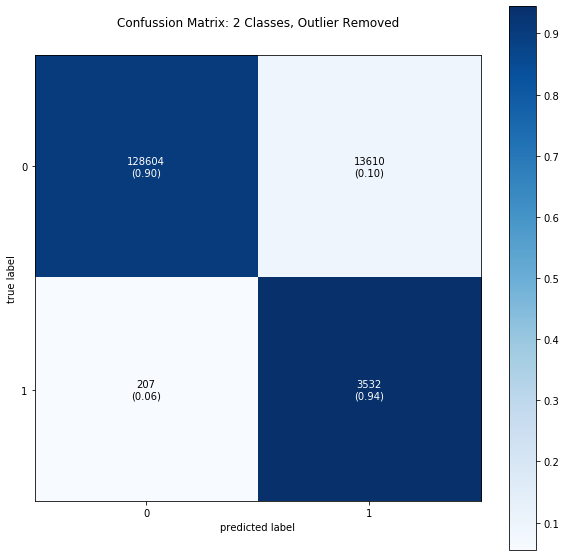

In [20]:
conf=sklearn.metrics.confusion_matrix(Y_test,pred,labels=[0,1])
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               figsize=(10,10))
plt.title('Confussion Matrix: 2 Classes, Outlier Removed')
# plt.savefig('./graphs/conf_2_outliers.png')

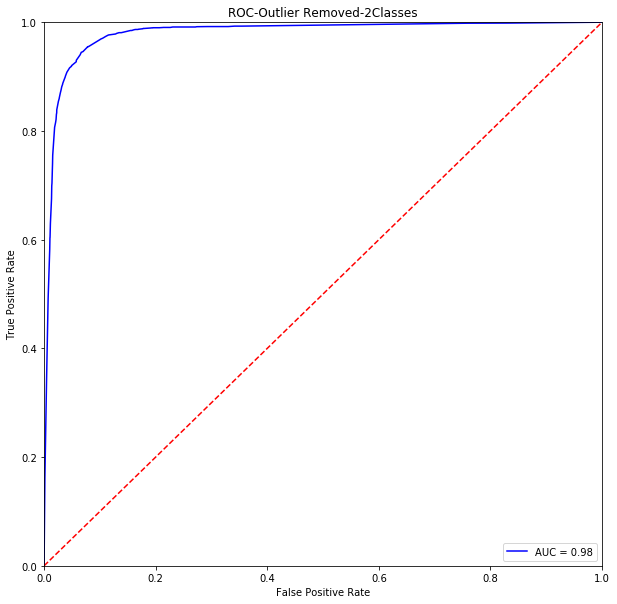

In [34]:
prob=model.predict_proba(X_test)
fig,ax=plt.subplots(figsize=(10,10))
preds = prob[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(Y_test, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('ROC-Outlier Removed-2Classes')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('./graphs/roc_2_outlier.png')
plt.show()

In [42]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=Y_test.tolist(), predict_vector=pred)
print (cm.AUC)
print (cm.AUCI)
print (cm.Kappa)

{0: 0.9434626823806516, 1: 0.9434626823806516}
{0: 'Excellent', 1: 'Excellent'}
0.2719382318126867


## Predicting Clicks

In [46]:
test=df_out
Y_test=test["clicks_level"]
X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

In [47]:
Y_test.value_counts()

0    670699
1     12298
Name: clicks_level, dtype: int64

Text(0.5, 1.05, 'Confussion Matrix: 2 Classes, Outlier Removed')

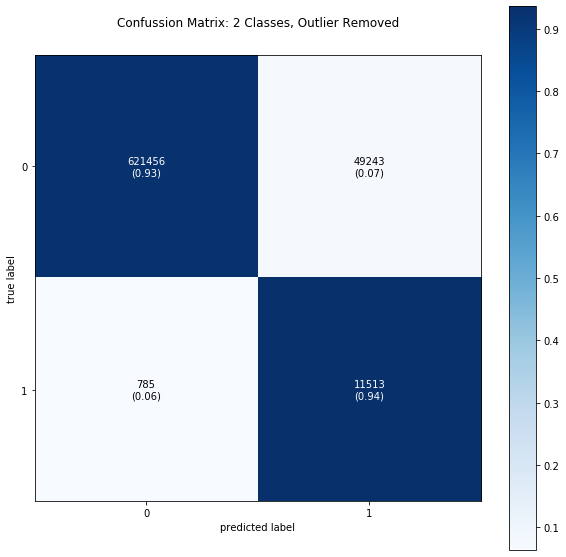

In [48]:
pred=model.predict(X_test)
conf=sklearn.metrics.confusion_matrix(Y_test,pred,labels=[0,1])
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               figsize=(10,10))
plt.title('Confussion Matrix: 2 Classes, Outlier Removed')
# plt.savefig('./graphs/conf_2_outliers.png')

In [50]:
df_out['pred_level1']=pred

In [56]:
# TimeSeries Split
train=df_out[df_out["pred_level1"]==1]
train=train[train["nDate"]<'2019-09-15']
Y_train=train["tomorrow_net_clicks"]
X_train=train.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

test=df_out[df_out["pred_level1"]==1]
test=test[test["nDate"]>='2019-09-15']
Y_test=test["tomorrow_net_clicks"]
X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)

In [60]:
X_test.shape,X_train.shape

((17142, 61), (43614, 61))

In [68]:
from math import sqrt
eset = [(X_train, Y_train), (X_test, Y_test)]
xg_reg = xgboost.XGBRegressor(learning_rate = 0.08,early_stopping_rounds=10,
                              max_depth = 5, n_estimators = 20,verbose=True,n_jobs=-1)
xg_reg.fit(X_train,Y_train,eval_set=eset)
ypred=xg_reg.predict(X_test)
print (sklearn.metrics.mean_absolute_error(Y_test.values,ypred))
print (sqrt(sklearn.metrics.mean_squared_error(Y_test.values,ypred)))

[08:21:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.48203	validation_1-rmse:1.67233


/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1]	validation_0-rmse:1.40344	validation_1-rmse:1.62221
[2]	validation_0-rmse:1.33194	validation_1-rmse:1.57489
[3]	validation_0-rmse:1.26278	validation_1-rmse:1.53585
[4]	validation_0-rmse:1.20026	validation_1-rmse:1.4928
[5]	validation_0-rmse:1.14354	validation_1-rmse:1.44944
[6]	validation_0-rmse:1.09197	validation_1-rmse:1.41576
[7]	validation_0-rmse:1.04508	validation_1-rmse:1.39236
[8]	validation_0-rmse:1.00284	validation_1-rmse:1.36674
[9]	validation_0-rmse:0.963831	validation_1-rmse:1.3399
[10]	validation_0-rmse:0.928464	validation_1-rmse:1.31606
[11]	validation_0-rmse:0.896482	validation_1-rmse:1.29474
[12]	validation_0-rmse:0.867334	validation_1-rmse:1.27544
[13]	validation_0-rmse:0.840942	validation_1-rmse:1.25898
[14]	validation_0-rmse:0.817232	validation_1-rmse:1.24623
[15]	validation_0-rmse:0.795209	validation_1-rmse:1.23385
[16]	validation_0-rmse:0.775214	validation_1-rmse:1.22286
[17]	validation_0-rmse:0.758091	validation_1-rmse:1.21341
[18]	validation_0-rmse:0.741074	v

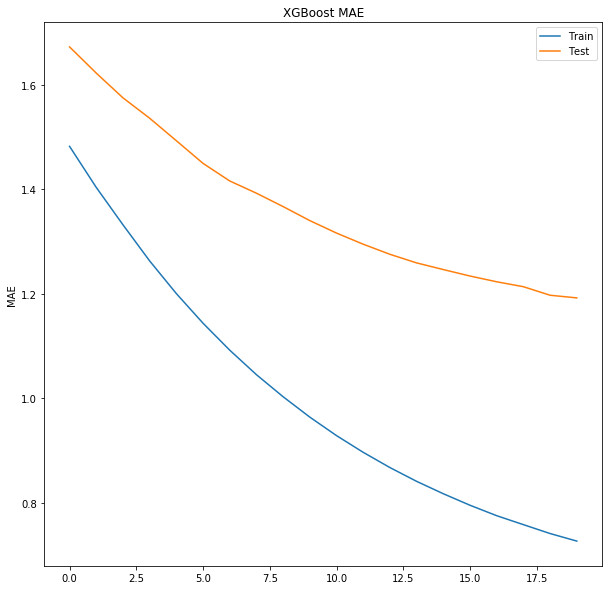

In [69]:
# retrieve performance metrics
results = xg_reg.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost MAE')
# plt.savefig('/home/spideysloth/mae.png')
plt.show()

## Predictions

In [75]:
# Level 1
test=df
Y_test=test["clicks_level"]
X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)
df["pred_level1"]=model.predict(X_test)

In [80]:
test=df[df["pred_level1"]==1]
X_test=test.drop(['nDate','query','date','clicks_level','tomorrow_net_clicks'],axis=1)
pred=xg_reg.predict(X_test)

In [82]:
df=df.assign(actual_clicks=0)

In [83]:
df.loc[df['pred_level1']==1, 'actual_clicks'] =pred

In [93]:
print (sklearn.metrics.mean_absolute_error(df.tomorrow_net_clicks,df.actual_clicks))
print (sqrt(sklearn.metrics.mean_squared_error(df.tomorrow_net_clicks,df.actual_clicks)))

0.023036373497706885
0.20380286285694682


In [90]:
df[df.actual_clicks<0]=0

In [91]:
df.actual_clicks.min()

0.0

In [89]:
df[df.tomorrow_net_clicks==df.tomorrow_net_clicks.max()]

,date,query,tomorrow_net_clicks,bot_clicks_feature,bcfeature1,bcfeature2,bcfeature3,bcfeature4,cfeature4,ifeature4,...,roll_i_feature3_all,roll_i_feature7_all,roll_i_feature30_all,roll_p_feature2_all,roll_p_feature3_all,roll_p_feature7_all,roll_p_feature30_all,nDate,pred_level1,actual_clicks
746917,2019-08-29,mattress stores,58,63,16,5,8,12,20,628,...,6989.333333,7101.571429,6531.466667,29.418031,29.619031,29.673803,28.831731,2019-08-29,1,36.572536


In [95]:
import joblib
joblib.dump(model,'./models/xg_Classifier_level1.dat')
joblib.dump(xg_reg,'./models/xg_Regressor_level2.dat')

['./models/xg_Regressor_level2.dat']

In [16]:
# # groups=gb.groups
# # # groups.|
# # index=[]
# # for key in groups.keys():
    
# #     dummy_df=df.iloc[groups[key]].drop(['tomorrow_net_clicks','clicks_level','bot_clicks_feature'],axis=1)
# #     Q1 = dummy_df.quantile(0.25)
# #     Q3 = dummy_df.quantile(0.75)
# #     IQR = Q3 - Q1
    
# #     df_out = dummy_df[~((dummy_df < (Q1 - 3 * IQR)) |(dummy_df > (Q3 + 3 * IQR))).any(axis=1)]
    
# #     index.append(df_out.index)
# #     print(key,dummy_df.shape,df_out.shape)
#   import itertools
# ind=list(itertools.chain.from_iterable(index))  

In [7]:
df=df.iloc[ind]

In [8]:
df.tomorrow_net_clicks.value_counts()

0    734699
1       214
2        11
3         2
Name: tomorrow_net_clicks, dtype: int64

In [5]:
Q1 = dummy_df.quantile(0.25)
Q3 = dummy_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

bot_clicks_feature         0.000000
bcfeature1                 0.000000
bcfeature2                 0.000000
bcfeature3                 0.000000
bcfeature4                 0.000000
cfeature4                  0.000000
ifeature4                  0.000000
pfeature4                  0.000000
cfeature5                  0.000000
cfeature6                  0.000000
cfeature7                  0.000000
ifeature5                  0.000000
ifeature6                  0.000000
ifeature7                  0.000000
pfeature5                  0.000000
pfeature6                  6.000000
pfeature7                 12.000000
roll_c_feature2            0.000000
roll_c_feature3            0.000000
roll_c_feature7            0.000000
roll_c_feature30           0.000000
roll_i_feature2            0.500000
roll_i_feature3            0.333333
roll_i_feature7            0.285714
roll_i_feature30           0.300000
roll_p_feature2            0.000000
roll_p_feature3            0.000000
roll_p_feature7            0

In [12]:
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [13]:
df_out['clicks_level'].value_counts()

0    478797
1       116
2        12
Name: clicks_level, dtype: int64

In [14]:
df_out["nDate"]=pd.to_datetime(df_out.date,format='%Y-%m-%d')
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')

/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df.nDate.max(),df.nDate.min()

(Timestamp('2019-10-22 00:00:00'), Timestamp('2019-06-21 00:00:00'))

In [14]:
df.set_index('nDate', inplace=True)
# df_out.set_index('nDate', inplace=True)

In [21]:
pd.date_range(start = '2019-06-21' , end = '2019-10-22' ).difference(df.nDate)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [18]:
pd.date_range(start = '2019-06-26' , end = '2019-10-02' ).difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

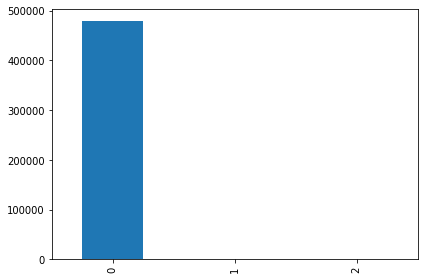

In [19]:
pd.value_counts(df_out['clicks_level']).plot.bar()
plt.tight_layout()